<div style="text-align: center;"> <img align=middle src="https://qwintry.com/files/article/159/images/amazon-pic.png/"> </div>

# Проект 6. "Рекомендательная система в сфере онлайн-ритейла"
# Выполнен Шашановым М. (SF-DST-43)

# Project Task

Рассматривается задача увеличения среднего чека розничной продажи товаров в интернет-магазине компании Amazon. Одним из способов является качественная рекомендация на сайте магазина. Чем точнее и лучше товар рекомендуется онлайн-пользователю, тем чаще добавляется в корзину вместе с основным товаром, с высокой вероятностью увеличивая средний чек покупки. <br><br> Рекомендации к товару (item) будут даваться в виде списка наиболее подходящих других товаров (Content based filtering). Выбрана оффлайн-модель, когда 1 раз обученная модель ML возвращает векторные представления объектов (embeddings), используемые для поиска рекомендаций. Плюсами оффлайн-модели является отсутствие затрат на предсказание во время работы, минусами - невозможность давать пользователям персональные рекомендации. <br><br> На этапе создания baseline модели используется библиотека LightFM, выполняющая матричное разложение (ALS) рейтингов товаров и возвращающая набор векторных представлений.

# Setup

Импортируем необходимые библиотеки и отдельный kernel module с функциями предобработки и визуализации данных

In [1]:
import numpy as np
import pandas as pd
import lightfm
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_confusion_matrix, confusion_matrix
import scipy.sparse as sparse
import scipy
from pprint import pprint
from skopt import forest_minimize
from datetime import date, datetime, timedelta
import sys
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import rec_challenge_kernel_module as km

# Настройки Pandas
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.options.mode.chained_assignment = None

# Настройки Seaborn
sns.set()

In [2]:
!pip install --upgrade pip
!pip install nmslib
import nmslib

     |████████████████████████████████| 1.6 MB 596 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1
    Uninstalling pip-20.1:
      Successfully uninstalled pip-20.1
     |████████████████████████████████| 13.5 MB 590 kB/s eta 0:00:01


Зафиксируем версии библиотек для воспроизводимости результатов на других плаформах

In [3]:
print('Python  :', sys.version.split('\n')[0])
print('Pandas  :', pd.__version__)
print('Numpy   :', np.__version__)
print('Scipy   :', scipy.__version__)
print('Sklearn :', sklearn.__version__)
print('Lightfm :', lightfm.__version__)
print('Nmslib  :', nmslib.__version__)

!pip freeze > requirements.txt

Python  : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Pandas  : 1.0.3
Numpy   : 1.18.1
Scipy   : 1.4.1
Sklearn : 0.22.2.post1
Lightfm : 1.15
Nmslib  : 2.1.1


Установим основные параметры модели LightFM. Один поток выполнения и зафиксированный RANDOM_SEED обеспечивают повторяемый результат (score) при каждом повторении расчетов

In [4]:
RANDOM_SEED    = 42
NUM_THREADS    = 1 # число потоков
NUM_COMPONENTS = 30 # число параметров вектора
NUM_EPOCHS     = 20 # число эпох обучения
LR             = 0.1 # исходный темп обучения

Укажем дату для вычисления количества дней с момента отзыва

In [5]:
current_date = pd.to_datetime('01/09/2021')

# Data

В директории input находятся следующие файлы

In [6]:
filename_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filename_list.append(os.path.join(dirname, filename))

display(filename_list)

['/kaggle/input/recommendationsv4/sample_submission.csv',
 '/kaggle/input/recommendationsv4/train.csv',
 '/kaggle/input/recommendationsv4/test.csv',
 '/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json']

Загрузим историю оценок пользователя вместе с отзывом на товар (train), данные для теста (test, submission), а также дополнительные метаданные о товарах в виде json-файла

In [7]:
train = pd.read_csv(filename_list[1], low_memory=False)
test = pd.read_csv(filename_list[2], low_memory=False)
submission = pd.read_csv(filename_list[0])

# Построчно прочитаем json
with open(filename_list[3]) as file:
    meta_list = []
    for line in file.readlines():
        meta_list.append(json.loads(line))

meta_data = pd.DataFrame(meta_list)

В загруженных данных есть следующий признаки:
* userid - id пользователя
* itemid - id товара
* id - id для предсказания
* overall - рейтинг, который поставил пользователь
* rating - нормированный (бинарный) рейтинг
* verified - был ли отзыв верифицирован
* reviewTime - когда был отзыв написан
* reviewerName - имя пользователя
* reviewText - текст отзыва
* summary - сжатый отзыв
* vote - количество голосований за отзыв
* style - метаданные
* image - изображение продукта
* asin - Amazon Standard Identification Number, уникальный идентификатор товара

Получим первичную информацию о загруженных датасетах

In [8]:
data = meta_data
display(data.info(), data.isna().sum(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


None

category             0
description      35407
title                4
brand            11422
rank             11715
also_view       166197
main_cat          1493
price           155073
asin                 0
also_buy        203877
image           136995
date            277546
feature         270835
details          13886
similar_item    286953
tech1           286465
fit             287205
dtype: int64

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN


Около трети признаков в meta_data содержат большой процент пропусков, скорее всего непригодны для исследования и применения при обучении модели. Основной столбец asin без пропусков

In [9]:
data = train
display(data.info(), data.isna().sum(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


None

overall                0
verified               0
reviewTime             0
asin                   0
reviewerName         176
reviewText           279
summary              170
unixReviewTime         0
vote              739155
style             413489
image             850753
userid                 0
itemid                 0
rating                 0
dtype: int64

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


Основные столбцы не содержат пропусков (userid, itemid, rating). Несколько прочих признаков можно выбросить из-за большого количества неуказанных значений

In [10]:
data = test
display(data.info(), data.isna().sum(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


None

verified               0
reviewTime             0
asin                   0
reviewerName          47
unixReviewTime         0
vote              246503
style             138285
image             283597
userid                 0
itemid                 0
Id                     0
dtype: int64

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


В test аналогично, т.е. основные признаки без пропусков, некоторые с большим процентом пропущенных в дальнейшем выбросим

## Data Preprocessing

### Meta

In [11]:
meta_data.drop(columns=['fit'], inplace=True) # признак с большим кол-вом пропусков, осталось 16 столбцов
print(meta_data.duplicated(subset=['asin']).sum(), meta_data.shape)

3697 (287209, 16)


В метаданных есть дубликаты по признаку asin в количестве 3697. Удалим такие повторы для корректной работы с датафреймом, так как asin должен быть уникальным идентификатором товара без повторений

In [12]:
meta_data_str = km.transform_meta_data_into_str(meta_data.copy())
print(meta_data_str.duplicated(subset=['asin']).sum(), meta_data_str.duplicated().sum(), meta_data_str.shape)

meta_data_str.drop_duplicates(inplace=True)
meta_data = meta_data.loc[meta_data_str.index, :]

print(meta_data_str.duplicated(subset=['asin']).sum(), meta_data.duplicated(subset=['asin']).sum())
print(meta_data_str.shape, meta_data.shape)

3697 3697 (287209, 16)
0 0
(283512, 16) (283512, 16)


Дубликаты по asin в тоже время являются полными дубликатами по всем остальным признакам, т.е. такие повторы можно просто удалить из meta_data. Подготовим метаданные для дальнейшего объединения с train и test, сгенерировав дополнительные признаки товара и обработав существующие признаки (заполнение пропусков, получение числовых значений из строк и пр.)

In [13]:
# Очистка данных
meta_data = km.prepare_meta_data(meta_data)

# Дополнительные признаки
meta_data['num_also_buy'] = meta_data['also_buy'].str.len().fillna(0).astype(np.uint32)
meta_data['num_also_view'] = meta_data['also_view'].str.len().fillna(0).astype(np.uint32)

meta_data_cols = ['asin',
                  'brand',
                  'main_cat',
                  'price',
                  'rank',
                  'num_also_buy',
                  'num_also_view',
]

meta_data_prepared = meta_data.copy()
meta_data_for_merge = meta_data[meta_data_cols]
display(meta_data_for_merge.info(), meta_data_for_merge.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283512 entries, 0 to 287208
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   asin           283512 non-null  object 
 1   brand          283512 non-null  object 
 2   main_cat       283512 non-null  object 
 3   price          283512 non-null  float64
 4   rank           283512 non-null  float64
 5   num_also_buy   283512 non-null  uint32 
 6   num_also_view  283512 non-null  uint32 
dtypes: float64(2), object(3), uint32(2)
memory usage: 15.1+ MB


None

,asin,brand,main_cat,price,rank,num_also_buy,num_also_view
0,0681727810,Ariola Imports,Grocery,41.91,165.181,0,6
1,0853347867,Unknown,Grocery,11.75,315.867,23,0
2,1888861118,Unik Occasions,Amazon Home,29.95,669.941,0,1
3,1888861517,Other,Amazon Home,11.45,832.581,0,0
4,1888861614,Unik Occasions,Amazon Home,15.00,590.999,0,0


Дополнительно убедимся, что все значения asin из train и test есть в meta_data

In [14]:
# check_function = km.check_ndarrays_inclusion
# meta_asin = meta_data_for_merge.asin.sort_values().unique()

# display(check_function(train.asin.sort_values().unique(), meta_asin))
# display(check_function(test.asin.sort_values().unique(), meta_asin))

# display(check_function(meta_asin, train.asin.sort_values().unique()))
# display(check_function(meta_asin, test.asin.sort_values().unique()))

### Train

In [15]:
overall_prep = train.overall.apply(lambda elem: int(elem >= 4))
print((overall_prep != train.rating).sum())

0


Нормированные оценки пользователей в целевом признаке rating соответствуют ненормированным в overall, который удалим. Также удалим признаки с высоким процентом пропущенных значений. А reviewText и summary отсутствуют в test, поэтому далее не используются (по крайней мере для теста, но могут быть использованы для получения лучших эмбеддингов в качестве дополнительных признаков)

In [16]:
columns_to_drop_0 = ['vote', 'style', 'image'] # много пропущенных значений
columns_to_drop_1 = ['overall', 'reviewText', 'summary'] # отсутствуют в test
train.drop(columns=(columns_to_drop_0 + columns_to_drop_1), inplace=True) # осталось 8 столбцов

Подготовим данные в train, заполняя пропуски в оставшихся столбцах и проверим наличие дубликатов по идентификаторам

In [17]:
# Очистка данных
train = km.prepare_data(train)
km.print_duplicates_info(train)

Num of full duplicates: 36348
Num of duplicates by userid, itemid: 45197


В train есть как полные дубликаты всех столбцов, так и частичные по userid, itemid, что означает несколько рейтингов для одной пары пользователь-товар. Полные дубликаты можно сразу удалить, а повторы по userid, itemid необходимо дополнительно исследовать

In [18]:
train_num_rows_init = train.shape[0]
train.drop_duplicates(inplace=True)

data_duplicated, idx_to_remove = km.prepare_duplicates(train) # оставляем все 1 или самый "свежий" ноль
display(data_duplicated.head(15))

train.drop(index=idx_to_remove, inplace=True)
km.print_duplicates_info(train)
print(train.shape[0] == (train_num_rows_init - (36348 + len(idx_to_remove))))

,verified,reviewTime,asin,reviewerName,unixReviewTime,userid,itemid,rating
261365,1,2014-03-07,B00542YXFW,Kit Carson,2014-03-07,28,15137,1
777636,1,2014-12-08,B00542YXFW,Kit Carson,2014-12-08,28,15137,1
56805,0,2009-04-08,B000FKL0EU,Avid Camper,2009-04-08,31,2201,1
142186,1,2009-03-10,B000FKL0EU,Avid Camper,2009-03-10,31,2201,1
45621,1,2009-03-16,B000H7ELTW,Avid Camper,2009-03-16,31,2566,1
299049,1,2009-02-02,B000H7ELTW,Avid Camper,2009-02-02,31,2566,1
213114,1,2015-03-31,5463213682,Gre,2015-03-31,41,2,1
506624,1,2016-08-09,5463213682,Gre,2016-08-09,41,2,1
387885,0,2016-04-15,B000BD0SDU,Jonathan Smith,2016-04-15,64,1101,1
580750,1,2014-05-13,B000BD0SDU,Jonathan Smith,2014-05-13,64,1101,1


Num of full duplicates: 0
Num of duplicates by userid, itemid: 0
True


Из анализа повторов по userid, itemid видно, что один и тот же пользователь мог оставлять различные отзывы на данный товар в разные моменты времени. Обработаем следующим образом: в случае если в рейтинге только 1, оставим из них самый последний по дате, либо последний по дате отзыв с 0, если таковой есть в истории (т.е. сохраним количество нулей, т.к. их меньше). В итоге в train каких-либо дубликатов больше нет. <br><br> Далее добавим в train подготовленные метаданные о товарах. Дубликатов и пропусков нет, можно анализировать статистику признаков

In [19]:
sorted(train.columns)

['asin',
 'itemid',
 'rating',
 'reviewTime',
 'reviewerName',
 'unixReviewTime',
 'userid',
 'verified']

In [20]:
train = pd.merge(train, meta_data_for_merge, how="left", on="asin")
data = train
display(data.info(), data.isna().sum(), data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812698 entries, 0 to 812697
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   verified        812698 non-null  uint8         
 1   reviewTime      812698 non-null  datetime64[ns]
 2   asin            812698 non-null  object        
 3   reviewerName    812698 non-null  object        
 4   unixReviewTime  812698 non-null  datetime64[ns]
 5   userid          812698 non-null  int64         
 6   itemid          812698 non-null  int64         
 7   rating          812698 non-null  uint8         
 8   brand           812698 non-null  object        
 9   main_cat        812698 non-null  object        
 10  price           812698 non-null  float64       
 11  rank            812698 non-null  float64       
 12  num_also_buy    812698 non-null  uint32        
 13  num_also_view   812698 non-null  uint32        
dtypes: datetime64[ns](2), float64(2), in

None

verified          0
reviewTime        0
asin              0
reviewerName      0
unixReviewTime    0
userid            0
itemid            0
rating            0
brand             0
main_cat          0
price             0
rank              0
num_also_buy      0
num_also_view     0
dtype: int64

,verified,reviewTime,asin,reviewerName,unixReviewTime,userid,itemid,rating,brand,main_cat,price,rank,num_also_buy,num_also_view
0,1,2016-10-04,B01CPNIEQG,Heather,2016-10-04,102179,37138,1,Primal Palate Organic Spices,Grocery,9.95,19.771,85,54
1,1,2016-03-01,B006F63M8U,Linda Odom,2016-03-01,3625,17322,1,Swiss Miss,Grocery,18.49,5.591,94,0
2,1,2016-06-26,B00112O8NG,Desertblossom,2016-06-26,39495,5600,1,Torani,Grocery,11.75,0.000,13,2
3,1,2013-09-05,B00MRAQUM8,Connie L. Reaves,2013-09-05,72854,30249,1,Frontier,Grocery,44.95,168.917,97,0
4,1,2016-09-14,B000R7RN0G,Mike P.,2016-09-14,74859,4349,1,Miss Vickie'S,Grocery,11.75,61.690,91,51


### Test

Подготовим данные в test, проверив на наличие дубликатов

In [21]:
# Очистка данных
test = km.prepare_data(test)
test.drop(columns=columns_to_drop_0, inplace=True) # удаляем vote, style, image
km.print_duplicates_info(test)

Num of full duplicates: 0
Num of duplicates by userid, itemid: 5338
Num of duplicates by userid, itemid, Id: 0


Полных дубликатов нет, но есть повторы по userid, itemid с разными Id, что в принципе нормально (повтор предсказаний для одной пары пользователь-товар).

In [22]:
sorted(test.columns)

['Id',
 'asin',
 'itemid',
 'reviewTime',
 'reviewerName',
 'unixReviewTime',
 'userid',
 'verified']

In [23]:
test = pd.merge(test, meta_data_for_merge, how="left", on="asin") # из test строки не удалялись
data = test
display(data.info(), data.isna().sum(), data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285965 entries, 0 to 285964
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   verified        285965 non-null  uint8         
 1   reviewTime      285965 non-null  datetime64[ns]
 2   asin            285965 non-null  object        
 3   reviewerName    285965 non-null  object        
 4   unixReviewTime  285965 non-null  datetime64[ns]
 5   userid          285965 non-null  int64         
 6   itemid          285965 non-null  int64         
 7   Id              285965 non-null  int64         
 8   brand           285965 non-null  object        
 9   main_cat        285965 non-null  object        
 10  price           285965 non-null  float64       
 11  rank            285965 non-null  float64       
 12  num_also_buy    285965 non-null  uint32        
 13  num_also_view   285965 non-null  uint32        
dtypes: datetime64[ns](2), float64(2), in

None

verified          0
reviewTime        0
asin              0
reviewerName      0
unixReviewTime    0
userid            0
itemid            0
Id                0
brand             0
main_cat          0
price             0
rank              0
num_also_buy      0
num_also_view     0
dtype: int64

,verified,reviewTime,asin,reviewerName,unixReviewTime,userid,itemid,Id,brand,main_cat,price,rank,num_also_buy,num_also_view
0,1,2016-10-01,B001E5E3X0,Rudys Mom,2016-10-01,68877,7506,0,Panni,Grocery,39.05,51.991,75,0
1,1,2014-06-29,B005BYXX5E,Pharg,2014-06-29,50442,15530,1,Adobe Milling,Grocery,5.45,127.103,0,19
2,1,2015-05-19,B0052OK6OO,Dhalex,2015-05-19,64349,15049,2,Green Mountain Coffee Roasters,Grocery,54.96,207.107,0,3
3,1,2014-10-05,B003SO8HGE,Vanessa,2014-10-05,26206,11957,3,Organic India,Health & Personal Care,10.56,68.308,90,56
4,1,2013-11-11,B003XUJ564,R Mohrman,2013-11-11,59366,12173,4,Chef Boyardee,Grocery,30.96,6.931,71,0


### Submission

In [24]:
submission['rating'] = -1 # сбросим значения
display(submission.head())

,Id,rating
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1


### Additional Data

In [25]:
userid_list = train['userid'].values.tolist() + test['userid'].values.tolist()
itemid_list = train['itemid'].values.tolist() + test['itemid'].values.tolist()
asin_list = train['asin'].values.tolist() + test['asin'].values.tolist()
itemid_2_asin_dict = dict(zip(itemid_list, asin_list))
asin_2_itemid_dict = dict(zip(asin_list, itemid_list))

In [26]:
num_users = max(userid_list) + 1
num_items = max(itemid_list) + 1

In [27]:
missed_itemid_train = km.get_missed_ids(train, 'itemid')
missed_userid_train = km.get_missed_ids(train, 'userid')
print(len(missed_itemid_train), len(missed_userid_train))

18 48


В истории отзывов в train отсутствуют записи о 18 товарах и 48 пользователях, которые по идентификаторам присутствуют в списке и также есть в test

In [28]:
itemid_train = train['itemid'].unique()
itemid_test = test['itemid'].unique()
check_itemid_test = [itemid for itemid in itemid_test if not itemid in itemid_train]
sorted(check_itemid_test) == sorted(missed_itemid_train)

True

In [29]:
userid_train = train['userid'].unique()
userid_test = test['userid'].unique()
check_userid_test = [userid for userid in userid_test if not userid in userid_train]
sorted(check_userid_test) == sorted(missed_userid_train)

True

Получается, что в test есть как известные пользователи и товары, так и неизвестные с точки зрения train (они же пропущенные). При получении тестовых результатов для этих пользователей/товаров необходимо решать задачу холодного старта (cold start). <br><br> Сохраним отдельно метаданные известных товаров из train (вместе с itemid) для дальнейшего использования в прототипе рекомендательной системы. Эти данные достаточно компактны по размеру и содержат все необходимое для каждого товара

In [30]:
meta_data_for_pred = meta_data.copy()
meta_data_for_pred = meta_data_for_pred[meta_data_for_pred['asin'].isin(asin_list)]
meta_data_for_pred['itemid'] = meta_data_for_pred['asin'].map(asin_2_itemid_dict)

# Удалим ненужные столбцы для уменьшения объема данных
meta_data_for_pred.drop(columns=['also_view','also_buy','rank','date','feature','details','tech1', 'similar_item', 'num_also_buy', 'num_also_view'], inplace=True)

meta_data_for_pred.sort_values(by='itemid', inplace=True)
meta_data_for_pred.reset_index(drop=True, inplace=True)
display(meta_data_for_pred)
meta_data_for_pred.to_csv('meta_data_for_pred.csv', index=False)

,category,description,title,brand,main_cat,price,asin,image,itemid
0,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Teabags uses a new way to...,Lipton Yellow Label Finest Blend Tea Bags 100 ...,Lipton,Grocery,12.98,4639725183,[https://images-na.ssl-images-amazon.com/image...,0
1,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Lipton Yellow Label Tea use only the finest t...,Lipton Yellow Label Tea (loose tea) - 450g,Lipton,Grocery,12.46,4639725043,[https://images-na.ssl-images-amazon.com/image...,1
2,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","[20 Sachets, Empty contents into cup\nPour 8oz...",Organo Gold Cafe Supreme 100% Certified Ganode...,Organo Gold,Grocery,29.90,5463213682,[https://images-na.ssl-images-amazon.com/image...,2
3,"[Grocery & Gourmet Food, Sauces, Gravies & Mar...","[Mae Ploy Thai green curry paste., Ingredients...","Mae Ploy Green Curry Paste, 14 oz",Mae Ploy,Grocery,11.75,9742356831,[https://images-na.ssl-images-amazon.com/image...,3
4,"[Grocery & Gourmet Food, Cooking & Baking, Foo...",[This set is a great value from one of the gre...,"Ateco Food Coloring Kit, 6 colors",Harold Import Company,Amazon Home,11.75,B00004S1C5,NaN,4
...,...,...,...,...,...,...,...,...,...
41315,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...",[Crushed fruit blended with smooth & creamy yo...,"Chobani Drink Mixed Yogurt, Berry, 8 oz",Chobani,Grocery,11.75,B01H8ET97A,[https://images-na.ssl-images-amazon.com/image...,41315
41316,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[All Natural, Statements regarding dietary sup...","Chobani Flip Whole Milk Yogurt, Honey Pear, 12 oz",Chobani,Grocery,11.75,B01H8ET9G6,[https://images-na.ssl-images-amazon.com/image...,41316
41317,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[All Natural, Statements regarding dietary sup...","Chobani Flip Whole Milk Yogurt, Raspberry, 12 oz",Chobani,Grocery,11.75,B01H8FA2U2,[https://images-na.ssl-images-amazon.com/image...,41317
41318,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","[Resealable jar., This price is for one seven ...","Nescafe Taster's Choice Instant Coffee, House ...",Taster'S Choice,Grocery,11.75,B01HGBEYRU,[https://images-na.ssl-images-amazon.com/image...,41318


# Exploratory Data Analysis

Предварительно подготовив и очистив наши данные, проведем их разведывательный анализ

## Features

Сгруппируем признакаки по типу обработки (бинарные, категориальные, числовые), в конце сгенерируем несколько дополнительных признаков

In [31]:
bin_cols = []
cat_cols = []
num_cols = []

### verified

1    86.9 %
0    13.1 %
Name: verified, dtype: object

Num of missing values: 0


1    86.9 %
0    13.1 %
Name: verified, dtype: object

Num of missing values: 0


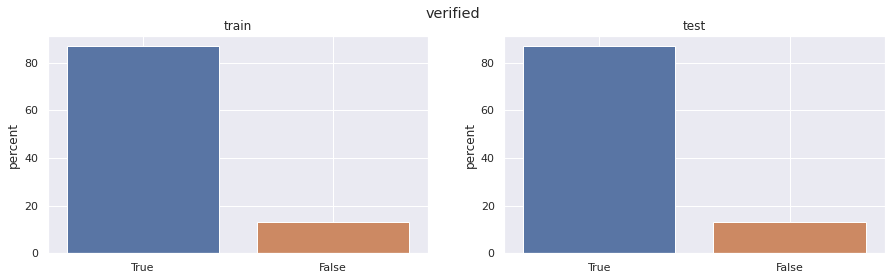

In [32]:
col = 'verified'
km.print_col_info(train[col])
km.print_col_info(test[col])
km.plot_top_categories(train, test, col)

Большинство отзывов являются верифицированными (87% против 13%) как в данных для обучения, так и в тестовых. Данный признак по типу является бинарным (2 возможных значения).

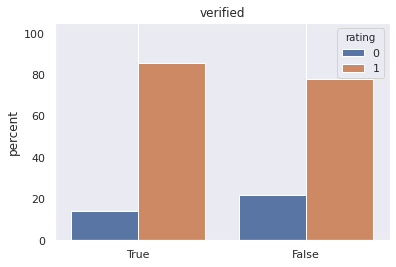

In [33]:
bin_cols.append(col)
km.plot_cat_col_vs_rating_percent(train, col)

Построив признак в зависимости от рейтинга, заметно, что среди верифицированных отзывов (verified=True) процент положительных несколько выше, чем среди неверифицированных. Это говорит о значимости данного признака

### reviewerName

Amazon Customer    3.7 %
Kindle Customer    0.7 %
John               0.1 %
Linda              0.1 %
Name: reviewerName, dtype: object

Num of missing values: 0


Amazon Customer    3.7 %
Kindle Customer    0.7 %
Linda              0.1 %
John               0.1 %
Name: reviewerName, dtype: object

Num of missing values: 0


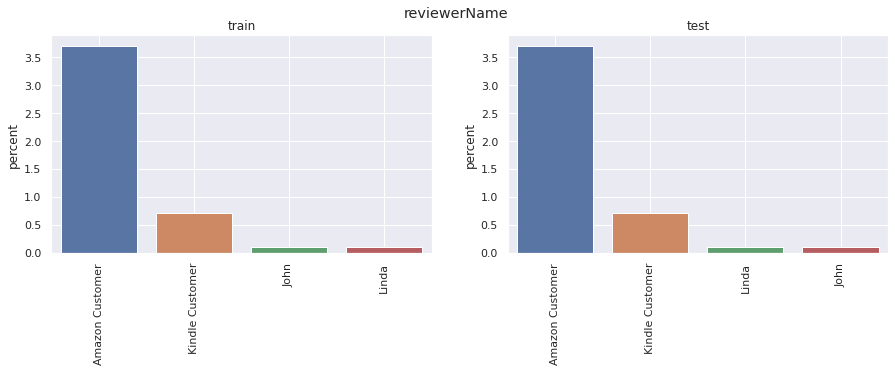

In [34]:
col = 'reviewerName'
km.print_col_info(train[col])
km.print_col_info(test[col])
km.plot_top_categories(train, test, col, rotation=90)

Это категориальный признак, наиболее частые категории как в train, так и в test - Amazon Customer, Kindle Customer. В целом сам по себе признак имени пользователя навряд ли можно использовать напрямую (т.к. совершенно различные пользователи могут иметь одинаковое имя и наоборот, тот же пользователь может оставлять отзывы под разными именами). Но на его основе можно сгенерировать новые признаки, такие как например пол, возможно национальность и пр, если удасться проанализировать статистику имен 

In [35]:
display(train.query(f"{col} == 'John'").sort_values(by=['unixReviewTime'], ascending=True))

,verified,reviewTime,asin,reviewerName,unixReviewTime,userid,itemid,rating,brand,main_cat,price,rank,num_also_buy,num_also_view
610925,1,2008-11-27,B000EMOCL2,John,2008-11-27,41627,1674,1,Dunkaroos,Grocery,11.75,478.361,0,7
413838,1,2009-04-03,B0010EIIPE,John,2009-04-03,16631,5544,1,Ferrero,Grocery,32.95,64.143,66,56
224269,0,2009-06-13,B000V9PH4O,John,2009-06-13,41627,4852,1,Lipton,Grocery,11.75,305.174,16,2
460559,1,2009-09-21,B000MIFRY4,John,2009-09-21,41627,3553,1,Campbell'S,Grocery,11.75,283.858,0,1
542296,0,2010-06-08,B002C0E5VG,John,2010-06-08,75225,10602,1,Breadtopia,Grocery,8.95,1.750,82,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273990,1,2018-07-11,B00TGA6NZG,John,2018-07-11,27544,32605,1,Smart Sips Coffee,Grocery,13.96,5.825,97,0
567438,1,2018-07-11,B00WQEB2BE,John,2018-07-11,27544,33667,1,Margaritaville,Grocery,7.99,12.124,88,0
676278,1,2018-07-21,B00PD2B68K,John,2018-07-21,2902,31461,1,Now Foods,Grocery,9.95,14.324,95,56
482924,1,2018-08-14,B01E5XTW24,John,2018-08-14,76956,37468,1,Green Mountain Coffee Roasters,Grocery,41.58,6.517,97,0


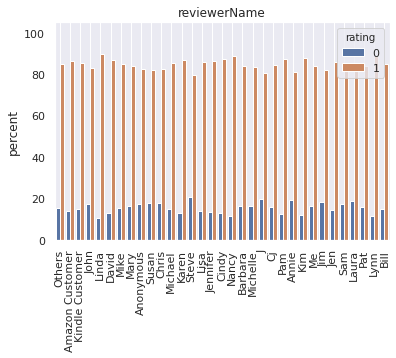

In [36]:
cat_cols.append(col)
km.plot_cat_col_vs_rating_percent(train, col, num_categories=32, rotation=90)

Признак выглядит значимым, прослеживается зависимость процента положительных рейтингов от категории имени, однако необходимо создать на его основе новые признаки, не используя имя пользователя напрямую при обучении модели

### unixReviewTime

In [37]:
col = 'unixReviewTime'
print(train[col].min().date(), train[col].max().date())
print(test[col].min().date(), test[col].max().date())
print()
km.print_col_info(train[col], num_categories=10)
km.print_col_info(test[col], num_categories=10)

2000-08-09 2018-10-02
2002-06-06 2018-10-02



2016-03-01    0.1 %
2016-07-14    0.1 %
2016-01-20    0.1 %
2015-06-03    0.1 %
2016-02-20    0.1 %
2016-02-18    0.1 %
2016-04-21    0.1 %
2016-01-22    0.1 %
2016-04-19    0.1 %
2017-01-03    0.1 %
Name: unixReviewTime, dtype: object

Num of missing values: 0


2016-03-01    0.1 %
2016-01-20    0.1 %
2015-06-03    0.1 %
2016-07-14    0.1 %
2015-04-29    0.1 %
2016-05-24    0.1 %
2016-01-22    0.1 %
2016-04-19    0.1 %
2016-02-18    0.1 %
2017-01-09    0.1 %
Name: unixReviewTime, dtype: object

Num of missing values: 0


В train представлены отзывы за период с 2000-08-09 по 2018-10-02, в test с 2002-06-06 по 2018-10-02. Признак не содержит пропусков, на его основе можно сгенерировать такие признаки, как кол-во прошедших дней с момента отзыва, некоторый временной период отзыва и пр. Признак выглядит значимым, отзывы по времени распределены приблизительно равномерно

In [38]:
col_2 = 'reviewTime'
display((train[col].dt.date != train[col_2].dt.date).sum())
display((test[col].dt.date != test[col_2].dt.date).sum())

0

0

Признак reviewTime повторяет признак unixReviewTime, далее используем какой-то один из них

### brand

Kind              2.6 %
Bob'S Red Mill    1.6 %
Planters          1.3 %
Twinings          1.0 %
Name: brand, dtype: object

Num of missing values: 0


Kind              2.7 %
Bob'S Red Mill    1.6 %
Planters          1.2 %
Twinings          1.1 %
Name: brand, dtype: object

Num of missing values: 0


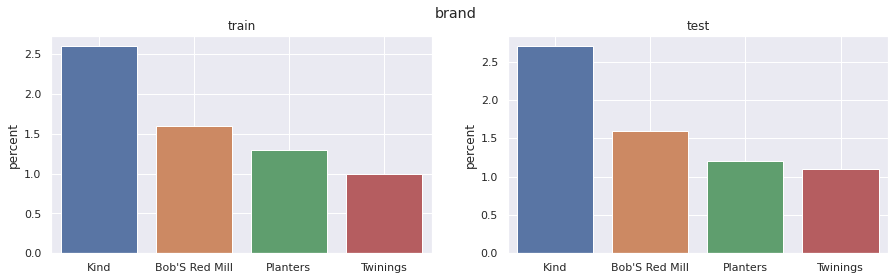

In [39]:
col = 'brand'
km.print_col_info(train[col])
km.print_col_info(test[col])
km.plot_top_categories(train, test, col)

Категориальный признак бренда товара не содержит пропусков, может быть использован в модели после применения One-Hot encoding. Распределение топовых брендов в train и test совпадает, встречаются как более частые, так и менее частые бренды.

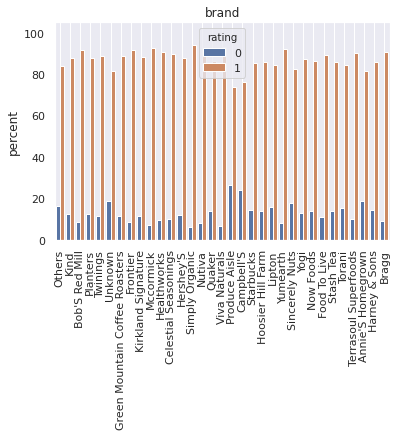

In [40]:
cat_cols.append(col)
km.plot_cat_col_vs_rating_percent(train, col, num_categories=32, rotation=90)

Признак выглядит значимым, поскольку доля положительных отзывов в целом довольно сильно может зависеть от бренда товара (примерно от 70% до 90%). Т.е. существуют более предпочитаемые и менее предпочитаемые бренды с точки зрения пользователей

### main_cat

Grocery                   94.7 %
Health & Personal Care     3.8 %
Amazon Home                0.8 %
All Beauty                 0.2 %
Name: main_cat, dtype: object

Num of missing values: 0


Grocery                   94.4 %
Health & Personal Care     4.0 %
Amazon Home                0.9 %
All Beauty                 0.2 %
Name: main_cat, dtype: object

Num of missing values: 0


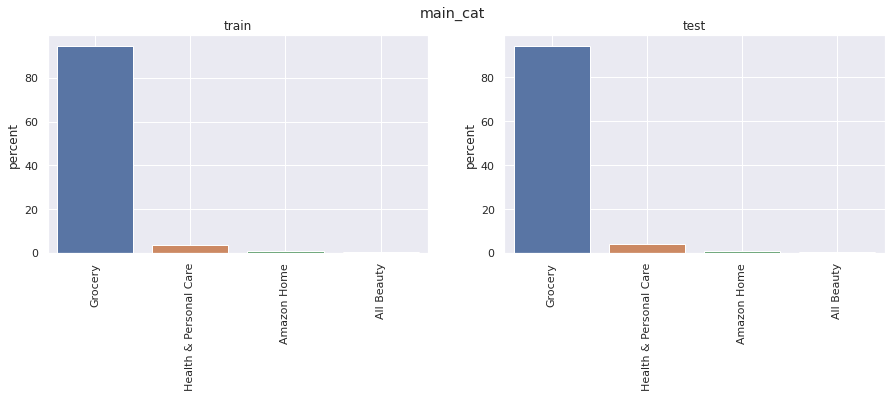

In [41]:
col = 'main_cat'
km.print_col_info(train[col])
km.print_col_info(test[col])
km.plot_top_categories(train, test, col, rotation=90)

Категориальный признак товара, не содержащий пропусков. Основную долю занимает Grocery - бакалейные товары, распределени остальных топовых категорий одинаково в train и test. Признак может напрямую использоваться при обучении модели

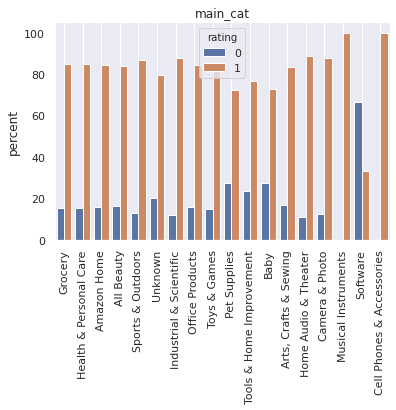

In [42]:
cat_cols.append(col)
km.plot_cat_col_vs_rating_percent(train, col, num_categories=40, rotation=90)

Признак является очень значимым, поскольку доля положительных отзывов на товары сильно связана с категориями товара. Например, для Musical Instruments доля положительных стремится к 100%, а для Software наоборот менее 40%. Возможно это связано с тем, что Amazon не специализируется на продаже некоторых категорий товаров. Для топовых категорий товаров доля положительных отзывов стабильно выше 80%.

### price

In [43]:
col = 'price'
km.print_col_info(train[col])
km.print_col_info(test[col])

11.75    30.4 %
14.99     1.7 %
13.67     1.2 %
19.99     1.1 %
Name: price, dtype: object

Num of missing values: 0


11.75    30.5 %
14.99     1.7 %
13.67     1.3 %
19.99     1.1 %
Name: price, dtype: object

Num of missing values: 0


Это числовой признак товара без пропусков. Заметно, что довольно часто встречаются товары с одинаковой ценой (11.75, 14.99), что вероятно обозначает какие-то скидки или акции на товар. Возможно это вынести в отдельный категориальный признак.

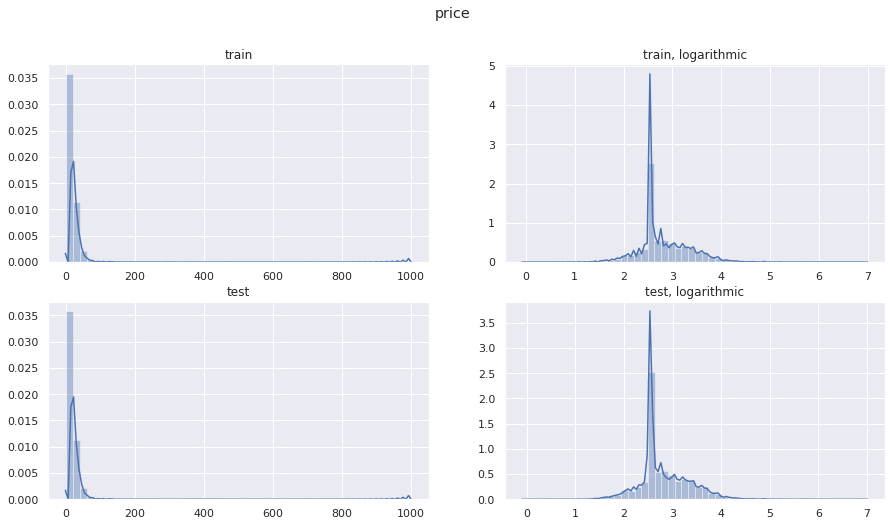

In [44]:
num_cols.append(col)
km.plot_num_col_unified(train, test, col)

Заметно, что распределения признака одинаковые в train и test, обладают ярко выраженным хвостом справа в области высоких цен. После логарифмирования распределение более похоже на нормальное с максимумом примерно в 2.54, что соответствует логарифму часто встречающейся цены 11.75.

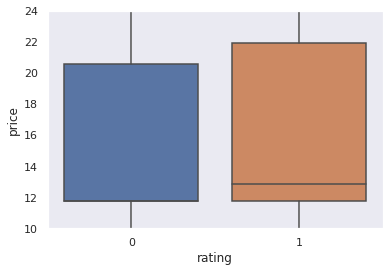

In [45]:
km.plot_num_col_vs_rating(train, col, ylim=[10, 24])

Товары с положительным рейтингом имеют более высокую цену, что говорит о значимости признака

In [46]:
km.print_percentiles_info(train[col])

mean         18.41
std          17.14
min           0.01
25%          11.75
50%          12.53
75%          21.84
max         999.00
iqr          10.09
out_high     36.98
out_low      -3.38
Name: price, dtype: float64

Наблюдаются выбросы в области высоких цен. Удалим их, если признак будет использоваться при обучении модели

### rank

In [47]:
col = 'rank'
km.print_col_info(train[col], 8)
km.print_col_info(test[col], 8)

0.000      4.2 %
18.000     0.9 %
4.575      0.5 %
2.949      0.5 %
72.000     0.3 %
19.796     0.2 %
142.261    0.2 %
242.748    0.2 %
Name: rank, dtype: object

Num of missing values: 0


0.000      4.4 %
18.000     0.9 %
2.949      0.6 %
4.575      0.5 %
72.000     0.3 %
142.261    0.3 %
19.796     0.3 %
11.923     0.3 %
Name: rank, dtype: object

Num of missing values: 0


Признак ранка товара содержит некоторое количеств пропусков, обозначеныхх нулями. Это числовой признак.

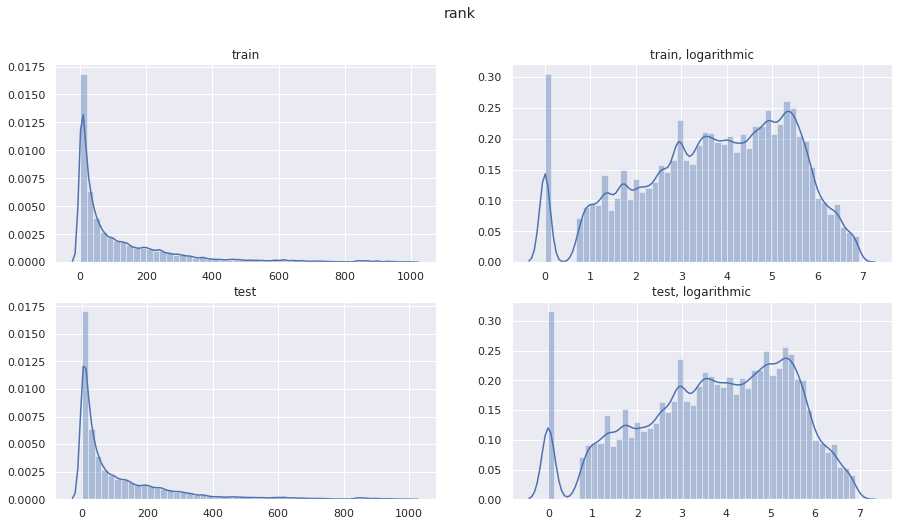

In [48]:
num_cols.append(col)
km.plot_num_col_unified(train, test, col)

После логарифмирования распределение признака похоже на равномерное

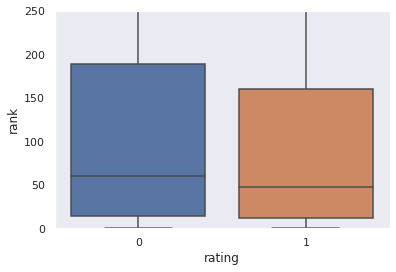

In [49]:
km.plot_num_col_vs_rating(train, col, ylim=[0, 250])

Товары с положительными отзывами имеют меньший ранк, что видимо означает отсчет этой величины с 0, т.е. большие значения ранка товара обозначают худшие позиции

In [50]:
km.print_percentiles_info(train[col])

mean        119.06
std         165.27
min           0.00
25%          11.92
50%          48.77
75%         165.22
max         999.00
iqr         153.30
out_high    395.16
out_low    -218.02
Name: rank, dtype: float64

У признака наблюдаются выбросы в области высоких значений 

### rating

1    84.7 %
0    15.3 %
Name: rating, dtype: object

Num of missing values: 0


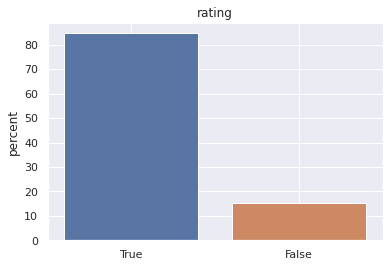

In [51]:
col = 'rating'
km.print_col_info(train[col])
km.plot_cat_col(train, col)

Целевая переменная rating из train содержит 85% положительных значений и 15% отрицательных (т.е. классы не сбалансированны в смысле бинарной классификации). Поэтому при подготовке исходных данных было важно сохранить кол-во нулей в процессе обработки истории отзывов

## Additional Features

На основе метаданных и данных отзывов сгенерируем несколько дополнительных признаков

### days_passed

Количество дней, прошедших с момента отзыва

In [52]:
col = 'days_passed'
train[col] = (current_date - train['unixReviewTime']).dt.days.astype(np.uint32)
test[col] = (current_date - test['unixReviewTime']).dt.days.astype(np.uint32)
km.print_col_info(train[col])
km.print_col_info(test[col])

1775    0.1 %
1640    0.1 %
1816    0.1 %
2047    0.1 %
Name: days_passed, dtype: object

Num of missing values: 0


1775    0.1 %
1816    0.1 %
2047    0.1 %
1640    0.1 %
Name: days_passed, dtype: object

Num of missing values: 0


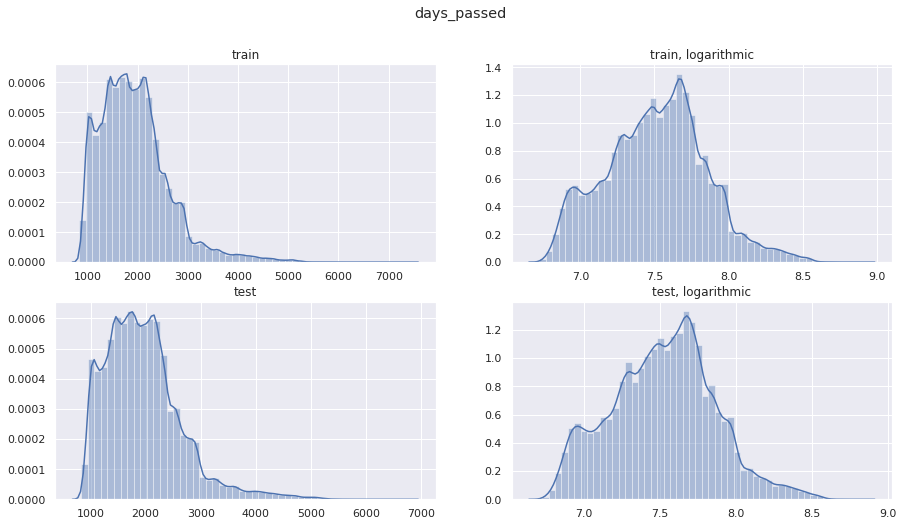

In [53]:
num_cols.append(col)
km.plot_num_col_unified(train, test, col)

Кол-во дней, прошедших с момента отзыва является числовым признаком. Без пропусков, распределение похоже в train и test. После логарифмирования более похоже на нормальное (нет длинного хвоста распределения в области больших значений). Но максимум распределения все равно сдвинут вправо 

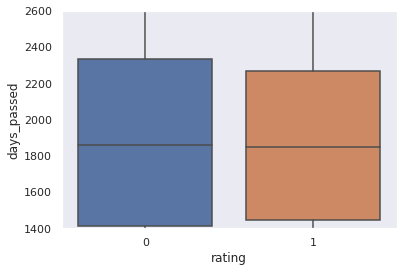

In [54]:
km.plot_num_col_vs_rating(train, col, ylim=[1400, 2600])

Для положительных рейтингов кол-во дней незначительно, но меньше (более свежие отзывы). Значимость признака покажет стастический тест

In [55]:
km.print_percentiles_info(train[col])

mean        1935.08
std          685.56
min          830.00
25%         1440.00
50%         1848.00
75%         2279.00
max         7458.00
iqr          839.00
out_high    3537.50
out_low      181.50
Name: days_passed, dtype: float64

Наблюдаются выбросы в области высоких значений. Их удаление означает удаление из истории слишком старых отзывов 

### num_also_buy

Количество товаров, покупаемых вместе с данным

In [56]:
col = 'num_also_buy'
km.print_col_info(train[col])
km.print_col_info(test[col])

0     14.5 %
95     5.2 %
96     4.0 %
94     3.8 %
Name: num_also_buy, dtype: object

Num of missing values: 0


0     14.2 %
95     5.3 %
96     4.2 %
94     3.7 %
Name: num_also_buy, dtype: object

Num of missing values: 0


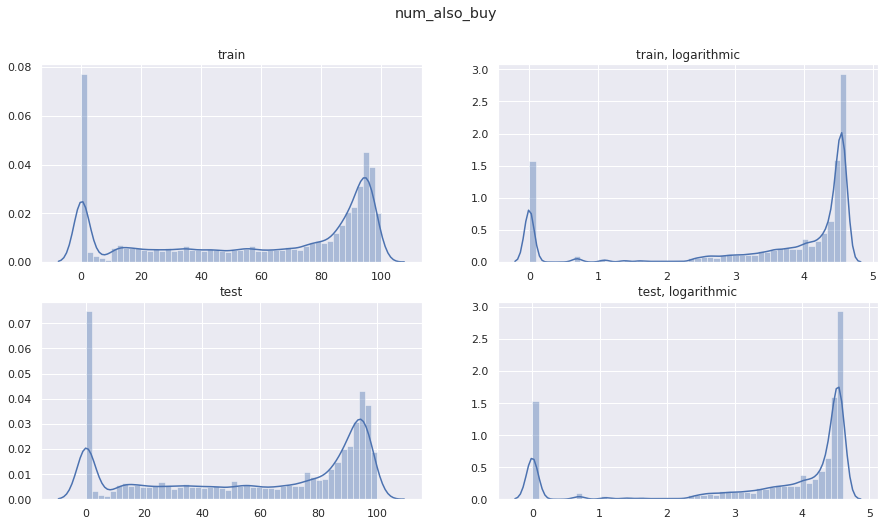

In [57]:
num_cols.append(col)
km.plot_num_col_unified(train, test, col)

Кол-во товаров, указанных как также покупаемые, является числовым признаком без пропусков. Распределение одинаково для train и test, обладает двумя максимумами - для нулевого значения и вобласти больших значений (более 90 товаров также покупаемых).

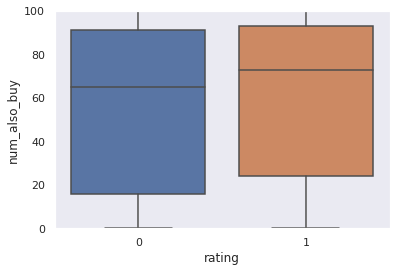

In [58]:
km.plot_num_col_vs_rating(train, col, ylim=[0, 100])

Заметно, что товары с положительным рейтингом в среднем имеют большее кол-во товаров, также покупаемых. Признак выглядит значимым

In [59]:
km.print_percentiles_info(train[col])

mean         58.24
std          36.47
min           0.00
25%          23.00
50%          72.00
75%          92.00
max         100.00
iqr          69.00
out_high    195.50
out_low     -80.50
Name: num_also_buy, dtype: float64

В данном признаке выбросы отсутствуют 

### num_also_view

Количество также просматриваемых товаров

In [60]:
col = 'num_also_view'
km.print_col_info(train[col])
km.print_col_info(test[col])

0     46.5 %
51     2.9 %
53     2.8 %
50     2.8 %
Name: num_also_view, dtype: object

Num of missing values: 0


0     45.3 %
51     3.2 %
50     2.9 %
53     2.9 %
Name: num_also_view, dtype: object

Num of missing values: 0


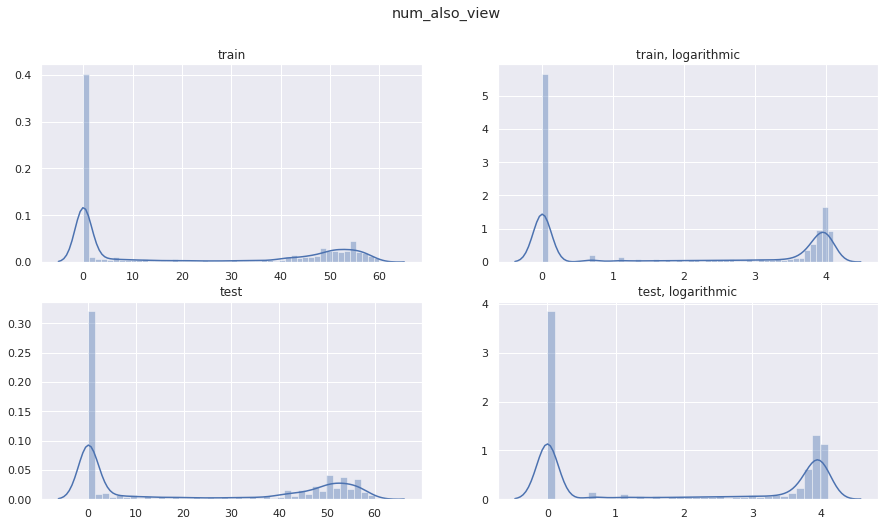

In [61]:
num_cols.append(col)
km.plot_num_col_unified(train, test, col)

Кол-во совместно просматриваемых товаров это числовой признак, не содержит пропусков. Как и для кол-ва также покупаемых товаров, распределение с двумя максимумами (в области 0 и значений выше 50). После логарифмирования форма распределения принципиально не меняется

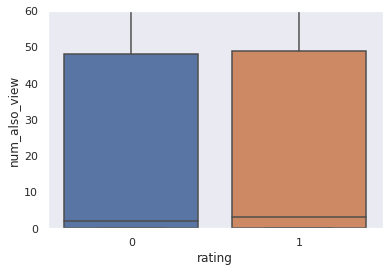

In [62]:
km.plot_num_col_vs_rating(train, col, ylim=[0, 60])

Больших различий не заметно, но для положительных рейтингов эта величина немного больше, чем для отзывов с отрицательным рейтингом

In [63]:
km.print_percentiles_info(train[col])

mean         21.19
std          23.97
min           0.00
25%           0.00
50%           3.00
75%          49.00
max          60.00
iqr          49.00
out_high    122.50
out_low     -73.50
Name: num_also_view, dtype: float64

Выбросов не наблюдается 

### brand_num_items

Количество тоавров данного бренда <br>Для получения этого признака вначале сгруппируем метаданные по брендам

In [64]:
agg_dict = {'asin' : 'nunique',
            'price' : 'median',
}

meta_data_brand_grouped = meta_data.groupby(['brand']).agg(agg_dict)
meta_data_brand_grouped.columns = ['num_items', 'mean_price']
meta_data_brand_grouped.sort_values(by=['num_items', 'mean_price'], ascending=False, inplace=True)
display(meta_data_brand_grouped)

,num_items,mean_price
brand,,
Unknown,12828,11.75
Black Tie Mercantile,1458,11.75
Trader Joe'S,1234,11.75
Mccormick,1026,11.75
The Nutty Fruit House,998,11.75
...,...,...
Rio Trading,1,0.78
Regular Show,1,0.75
Billy'S Farm,1,0.28


In [65]:
col = 'brand_num_items'
train[col] = train['brand'].apply(lambda brand: meta_data_brand_grouped.loc[brand, 'num_items']).astype(np.uint32)
test[col] = test['brand'].apply(lambda brand: meta_data_brand_grouped.loc[brand, 'num_items']).astype(np.uint32)
km.print_col_info(train[col], num_categories=8)
km.print_col_info(test[col], num_categories=8)

1      3.1 %
203    2.7 %
2      1.9 %
3      1.8 %
12     1.7 %
715    1.6 %
4      1.5 %
5      1.5 %
Name: brand_num_items, dtype: object

Num of missing values: 0


1      3.0 %
203    2.7 %
2      1.8 %
3      1.8 %
12     1.7 %
715    1.6 %
9      1.5 %
4      1.5 %
Name: brand_num_items, dtype: object

Num of missing values: 0


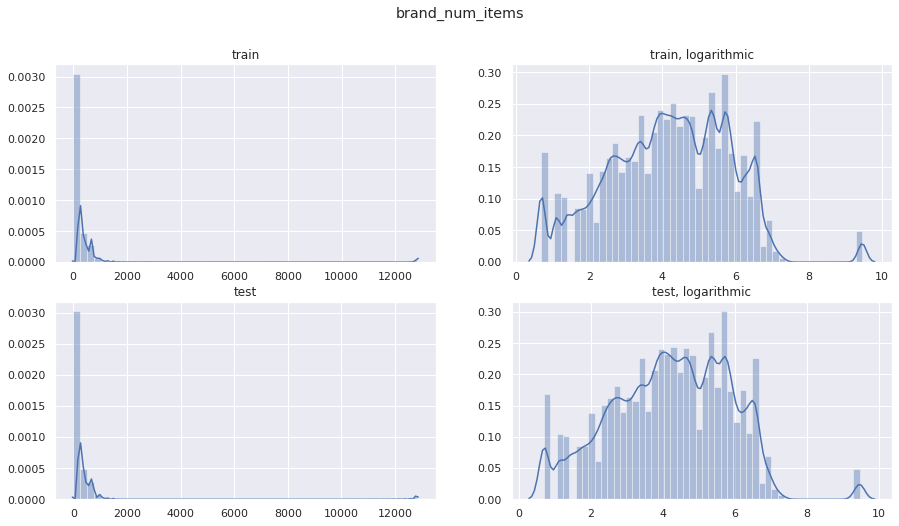

In [66]:
num_cols.append(col)
km.plot_num_col_unified(train, test, col)

Кол-во товаров данного бренда является числовым признаком, не содержит пропусков. Распределение в train и test обладает длинных хвостом в области высоких значений, который пропадает после логарифмирования признака. Интересно, что наиболее часто встречаются бренды с небольшим ассортиментом (от 1 до 9 товаров), там и с большим (203 или 715 товаров).

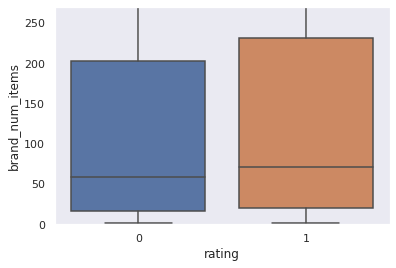

In [67]:
km.plot_num_col_vs_rating(train, col, ylim=[0, 270])

Заметно, что бренды с большим ассортиментом имеют более высокий процент положительнеых отзывов, что логично, т.к. у покупателя есть выбор. Признак выглядит значимым

In [68]:
km.print_percentiles_info(train[col])

mean          272.50
std          1192.16
min             1.00
25%            19.00
50%            69.00
75%           222.00
max         12828.00
iqr           203.00
out_high      526.50
out_low      -285.50
Name: brand_num_items, dtype: float64

Заметны выбросы в области высоких значений 

### brand_mean_price

Средняя (точнее медианная) цена товаров данного бренда

In [69]:
col = 'brand_mean_price'
train[col] = train['brand'].apply(lambda brand: meta_data_brand_grouped.loc[brand, 'mean_price']).astype(np.float32)
test[col] = test['brand'].apply(lambda brand: meta_data_brand_grouped.loc[brand, 'mean_price']).astype(np.float32)
km.print_col_info(train[col])
km.print_col_info(test[col])

11.750000    69.3 %
14.990000     0.9 %
21.629999     0.8 %
12.775000     0.8 %
Name: brand_mean_price, dtype: object

Num of missing values: 0


11.750000    69.3 %
14.990000     0.8 %
12.775000     0.8 %
21.629999     0.8 %
Name: brand_mean_price, dtype: object

Num of missing values: 0


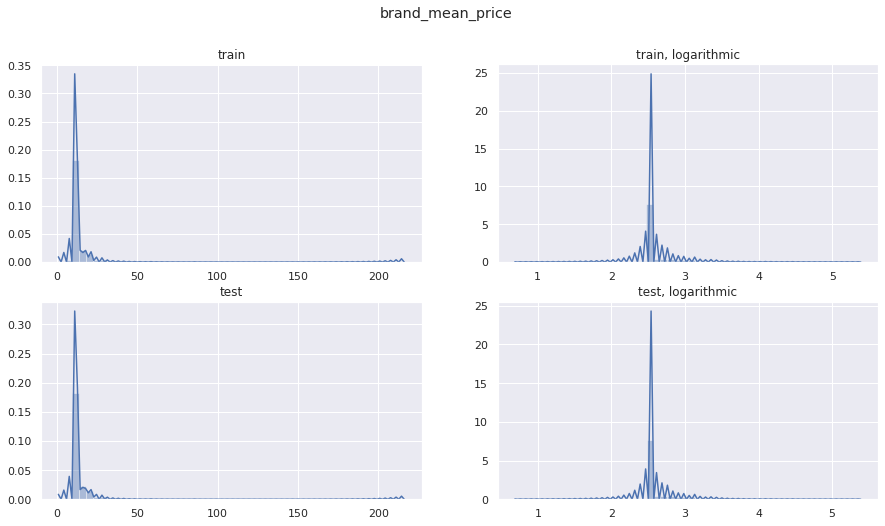

In [70]:
num_cols.append(col)
km.plot_num_col_unified(train, test, col)

Числовой признак без пропусков. Средняя цена по бренду обладает длинным хвостом распределения в области высоких значений, что убирается при помощи логарифмирования. Интересно, что в 70% случаев эта величина равна 11.75. Т.е. довольно много брендов, где все товары имеют равные или близкие цены.

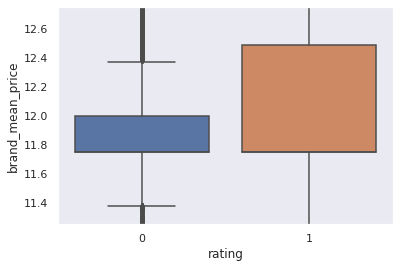

In [71]:
km.plot_num_col_vs_rating(train, col, ylim=[11.25, 12.75])

По распределению признака в зависимости от рейтинга заметно, что отзывы на товары бренда с низкой средней ценой (или равной 11.75), в целом негативные. Положительные отзывы были получены для брендов с более дорогими товарами. Признак явно значимый на первый взгляд. А отрицательные отзывы могут означать акционные товары низкого качества, распродаваемые со скидками 

In [72]:
km.print_percentiles_info(train[col])

mean         13.65
std           5.57
min           1.01
25%          11.75
50%          11.75
75%          12.43
max         216.00
iqr           0.68
out_high     13.45
out_low      10.73
Name: brand_mean_price, dtype: float64

Наблюдаются выбросы как в области высоких, так и в области низких значений 

### brand_verified_ratio

Процент верифицированных среди отзывов на товары данного бренда <br>Для начала нужно сгруппировать данные train по брендам

In [73]:
agg_dict = {'verified' : km.get_verified_percent}
train_brand_grouped = train.groupby(['brand']).agg(agg_dict)
train_brand_grouped.columns = ['verified_ratio']
train_brand_grouped.sort_values(by=['verified_ratio'], ascending=False, inplace=True)
display(train_brand_grouped)

def brand_2_verified_ratio(brand):
    if brand in train_brand_grouped.index:
        return train_brand_grouped.loc[brand, 'verified_ratio']
    else:
        return 50.

,verified_ratio
brand,
Las Sevillanas,100.0
Kuchle,100.0
Korean Red Ginseng,100.0
Kosciusko,100.0
Koska,100.0
...,...
Side Mates,0.0
Sibu Sura,0.0
Gillian'S,0.0


In [74]:
col = 'brand_verified_ratio'
train[col] = train['brand'].apply(brand_2_verified_ratio).astype(np.float32)
test[col] = test['brand'].apply(brand_2_verified_ratio).astype(np.float32)
km.print_col_info(train[col])
km.print_col_info(test[col])

100.000000    3.0 %
90.550003     2.6 %
91.379997     1.6 %
80.809998     1.3 %
Name: brand_verified_ratio, dtype: object

Num of missing values: 0


100.000000    3.1 %
90.550003     2.7 %
91.379997     1.7 %
80.809998     1.2 %
Name: brand_verified_ratio, dtype: object

Num of missing values: 0


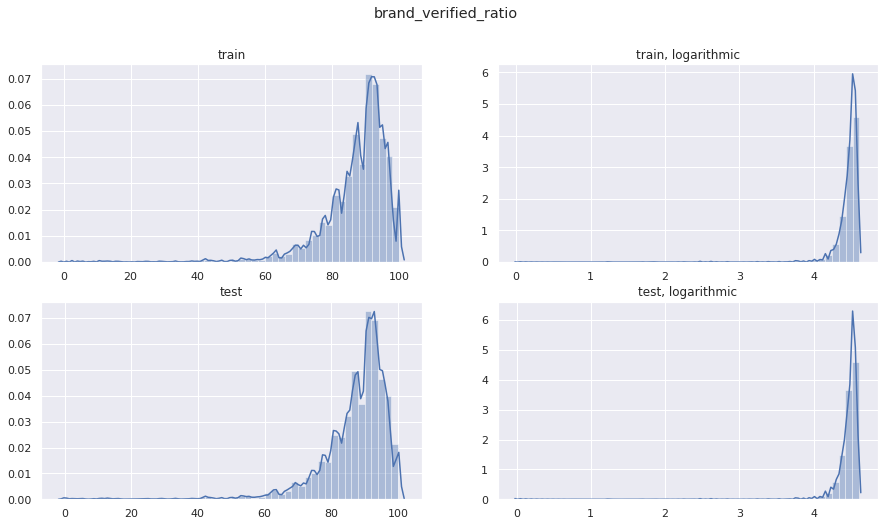

In [75]:
num_cols.append(col)
km.plot_num_col_unified(train, test, col)

Это числовой признак без пропусков. После логарифмирования распределение больше похоже на нормальное 

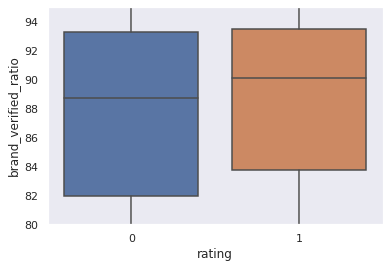

In [76]:
km.plot_num_col_vs_rating(train, col, ylim=[80, 95])

Признак значимый, поскольку среди положительных отзывов выше процент верификации отзывов на товары данного бренда

In [77]:
km.print_percentiles_info(train[col])

mean         86.93
std          11.12
min           0.00
25%          83.33
50%          89.95
75%          93.42
max         100.00
iqr          10.09
out_high    108.55
out_low      68.20
Name: brand_verified_ratio, dtype: float64

Наблюдаются выбросы в области небольших значений

В итоге, для дальнейшего использования определен следующий набор признаков 

In [78]:
feature_cols_dict = {'binary' : bin_cols, 'categorical' : cat_cols, 'numerical' : num_cols}
pprint(feature_cols_dict)

{'binary': ['verified'],
 'categorical': ['reviewerName', 'brand', 'main_cat'],
 'numerical': ['price',
               'rank',
               'days_passed',
               'num_also_buy',
               'num_also_view',
               'brand_num_items',
               'brand_mean_price',
               'brand_verified_ratio']}


## Features Correlation

Для получения значений корреляции и оценки значимости признаков, применим Label Encoding для категориальных признаков 

,reviewerName,brand,main_cat,reviewerName_le,brand_le,main_cat_le
0,Heather,Primal Palate Organic Spices,Grocery,35034,6262,6
1,Linda Odom,Swiss Miss,Grocery,54373,7579,6
2,Desertblossom,Torani,Grocery,23346,7998,6
3,Connie L. Reaves,Frontier,Grocery,18126,2770,6
4,Mike P.,Miss Vickie'S,Grocery,63064,5079,6


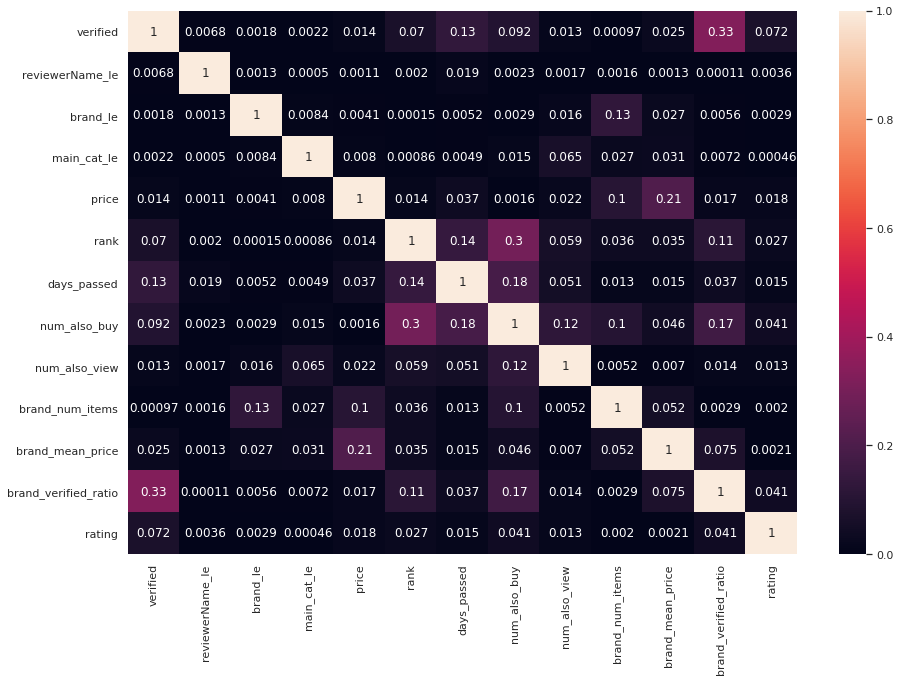

In [79]:
train_cat_cols_encoded = train.copy()
cat_cols_encoded = km.get_cat_cols_le(train_cat_cols_encoded, cat_cols)
display(train_cat_cols_encoded[cat_cols + cat_cols_encoded].head())
km.plot_corr_matrix(train_cat_cols_encoded, bin_cols + cat_cols_encoded + num_cols + ['rating'])

Высокая кореляция наблюдается между следующими признаками:
* verified и brand_verified_ratio
* price и brand_mean_price
* rank и num_also_buy

Корреляция первых двух пар объяснима, поскольку один из признаков получен на основе значений другого. Интересной является взаимосвязь rank и num_also_buy, которая видимо означает, что при покупке товара с хорошим рейтингом выше вероятность покупки каких-либо еще дополнительных товаров

## Features Importance

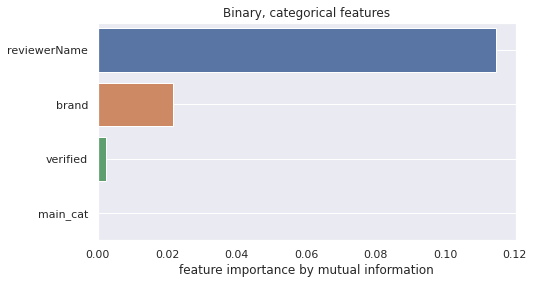

In [80]:
km.plot_bin_cat_importance(train_cat_cols_encoded, bin_cols + cat_cols_encoded)

Самым значимым среди бинарных и категориальных является reviewerName, однако его использование напрямую в модели под вопросом. Важно, что признак бренда товара тоже является значимым по сравнению с другими, что было использовано при генерации новых числовых признаков

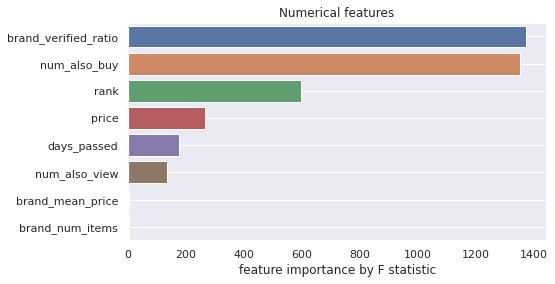

In [81]:
km.plot_num_importance(train_cat_cols_encoded, num_cols)

Среди числовых признаков наиболее значимыми являются brand_verified_ratio и num_also_buy. brand_verified_ratio является признаком бренда, num_also_buy является признаком товара. 

## Categorical One-Hot Encoding

Для испльзования категориальных признаков в обучении модели применим к ним One-Hot Encoding

In [82]:
all_features_cols = bin_cols + cat_cols + num_cols
print(len(all_features_cols))
all_id_cols = ['userid', 'itemid']

train_rating_col = train['rating']
train_for_combaning = train[all_features_cols + all_id_cols]

test_id_col = test['Id']
test_for_combaning = test[all_features_cols + all_id_cols]

12


Для корректной обработки категорий  этих признаков вначале объединим train и test в общий датафрейм

In [83]:
col = 'is_train'
train_for_combaning[col] = 1 # помечаем train
test_for_combaning[col] = 0 # помечаем test
data_combined = test_for_combaning.append(train_for_combaning, ignore_index=True, sort=False) # объединяем

In [84]:
print(data_combined.main_cat.nunique(), data_combined.brand.nunique(), data_combined.reviewerName.nunique())
data_combined.brand = km.get_top_categories_col(data_combined.brand, 20, 'Other')
data_combined.reviewerName = km.get_top_categories_col(data_combined.reviewerName, 20, 'Other')
print(data_combined.main_cat.nunique(), data_combined.brand.nunique(), data_combined.reviewerName.nunique())

18 8821 98033
18 20 20


В признаках brand и reviewerName слишком большое количество категорий, в итоге оставим по 20 топовых категорий, добавляя менее часто встречающеся в общую категорию Other. <br>Далее применяем One-Hot Encoding

In [85]:
data_for_model = pd.get_dummies(data_combined, columns=cat_cols) # data_combined не меняется
display(data_for_model.head())

train_for_model = data_for_model.query('is_train == 1').drop(columns=['is_train'])
train_for_model['rating'] = train_rating_col.values

test_for_model = data_for_model.query('is_train == 0').drop(columns=['is_train'])

,verified,price,rank,days_passed,num_also_buy,num_also_view,brand_num_items,brand_mean_price,brand_verified_ratio,userid,itemid,is_train,reviewerName_Amazon Customer,reviewerName_Anonymous,reviewerName_Barbara,reviewerName_Chris,reviewerName_Cindy,reviewerName_David,reviewerName_J,reviewerName_Jennifer,reviewerName_John,reviewerName_Karen,reviewerName_Kindle Customer,reviewerName_Linda,reviewerName_Lisa,reviewerName_Mary,reviewerName_Michael,reviewerName_Mike,reviewerName_Nancy,reviewerName_Other,reviewerName_Steve,reviewerName_Susan,brand_Bob'S Red Mill,brand_Campbell'S,brand_Celestial Seasonings,brand_Frontier,brand_Green Mountain Coffee Roasters,brand_Healthworks,brand_Hershey'S,brand_Kind,brand_Kirkland Signature,brand_Mccormick,brand_Nutiva,brand_Other,brand_Planters,brand_Produce Aisle,brand_Quaker,brand_Simply Organic,brand_Starbucks,brand_Twinings,brand_Unknown,brand_Viva Naturals,main_cat_All Beauty,main_cat_Amazon Home,"main_cat_Arts, Crafts & Sewing",main_cat_Baby,main_cat_Camera & Photo,main_cat_Cell Phones & Accessories,main_cat_Grocery,main_cat_Health & Personal Care,main_cat_Home Audio & Theater,main_cat_Industrial & Scientific,main_cat_Musical Instruments,main_cat_Office Products,main_cat_Pet Supplies,main_cat_Software,main_cat_Sports & Outdoors,main_cat_Tools & Home Improvement,main_cat_Toys & Games,main_cat_Unknown
0,1,39.05,51.991,1561,75,0,10,20.594999,93.330002,68877,7506,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,5.45,127.103,2386,0,19,4,16.570000,100.000000,50442,15530,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,54.96,207.107,2062,0,3,734,21.629999,92.769997,64349,15049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,10.56,68.308,2288,90,56,57,11.750000,89.290001,26206,11957,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,30.96,6.931,2616,71,0,98,11.750000,85.639999,59366,12173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [86]:
# display(train.shape, train_for_model.shape, test.shape, test_for_model.shape)
# train_2 = train_for_model.copy().drop(columns=bin_cols + num_cols + all_id_cols + ['rating'])
# test_2 = test_for_model.copy().drop(columns=bin_cols + num_cols + all_id_cols)
# display(train_2.shape, test_2.shape)

In [87]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# train_3 = data_combined.query('is_train == 1').drop(columns=['is_train'])
# test_3 = data_combined.query('is_train == 0').drop(columns=['is_train'])
# display(train_3.shape, test_3.shape)

# x_cat = OneHotEncoder(sparse=False).fit_transform(train_3[cat_cols].values)
# y_cat = OneHotEncoder(sparse=False).fit_transform(test_3[cat_cols].values)
# display(x_cat.shape, y_cat.shape)
# np.array_equal(train_2.values, x_cat), np.array_equal(test_2.values, y_cat)

# Baseline Model (LightFM)

В основе рекомендательной системы используется библиотека LightFM, реализующая методы матричного разложения. <br>Для начала предварительно перекодируем значения рейтингов в набор из 1 и -1, т.к. модель ожидает данные именно в таком формате

In [88]:
display(train_for_model['rating'].value_counts())
train_for_model['rating'] = train_for_model['rating'].map({1 : 1, 0 : -1})
display(train_for_model['rating'].value_counts())

1    688361
0    124337
Name: rating, dtype: int64

 1    688361
-1    124337
Name: rating, dtype: int64

## Evaluation

Чтобы работать с моделями в библиотеке LightFm, нужно создать разреженные матрицы. Будем хранить данные в формате COO (координатный формат представления данных). Вместо хранения всех значений, которые включают нулевые значения, сохраняются только ненулевые значения. В COO данные представлены в виде (строка, столбец, значение). Предварительно разделим обучающую выборку на 2 части для последующей валидации модели

In [89]:
train_for_eval, test_for_eval = train_test_split(train_for_model, test_size=0.25, random_state=RANDOM_SEED, shuffle=True)
ratings_coo = km.get_ratings_coo_matrix(train_for_eval) # COO формат данных
print(ratings_coo.get_shape() == (num_users, num_items))
display(ratings_coo.toarray()[:10,:10])
# print(ratings_coo.get_shape(), ratings_coo.getnnz(), ratings_coo.count_nonzero(), type(ratings_coo))

True


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Заметно, что в матрице значения разрежены. <br>По умолчанию заданы следующие параметры модели

In [90]:
pprint(km.get_std_model().get_params())

{'epsilon': 1e-06,
 'item_alpha': 0.0,
 'k': 5,
 'learning_rate': 0.1,
 'learning_schedule': 'adagrad',
 'loss': 'logistic',
 'max_sampled': 10,
 'n': 10,
 'no_components': 30,
 'random_state': RandomState(MT19937) at 0x7F24647E39E0,
 'rho': 0.95,
 'user_alpha': 0.0}


Далее обучим модель на тренировочной выборке, явно используя user_features и item_features в виде единичных матриц по всем товарам и пользователям соответственно

In [91]:
model = km.get_std_model()
user_features = km.get_features_from_ids(train_for_eval['userid'])
item_features = km.get_features_from_ids(train_for_eval['itemid'])

display(user_features.toarray()[:10,:10])
print()
display(item_features.toarray()[:10,:10])

# user_features = km.add_units_column(user_features)
# item_features = km.add_units_column(item_features)
# item_features = sparse.hstack([item_features.copy(), get_features_from_main_cat(train_data)])
# user_features = km.coo_to_csr_matrix(user_features)
# item_features = km.coo_to_csr_matrix(item_features)

model = model.fit(ratings_coo.copy(),
                  user_features=user_features,
                  item_features=item_features,
                  epochs=NUM_EPOCHS,
                  num_threads=NUM_THREADS)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Выше можно видеть единичные матрицы признаков. <br>Далее получим предсказания на тестовой выборке и оценим score модели

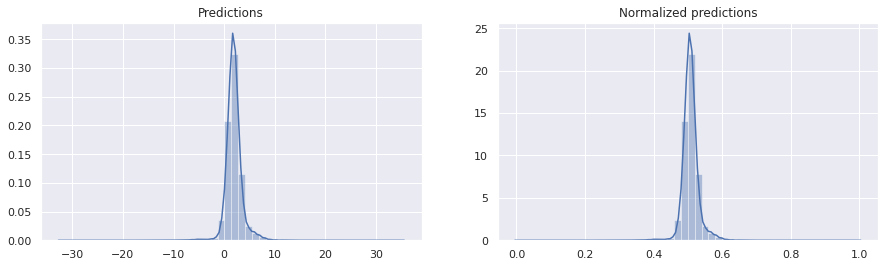

In [92]:
user_features = km.get_features_from_ids(test_for_eval['userid'])
item_features = km.get_features_from_ids(test_for_eval['itemid'])

# user_features = km.add_units_column(user_features)
# item_features = km.add_units_column(item_features)
# item_features = sparse.hstack([item_features.copy(), get_features_from_main_cat(test_data)])
# user_features = km.coo_to_csr_matrix(user_features)
# item_features = km.coo_to_csr_matrix(item_features)

preds = model.predict(test_for_eval.userid.values,
                      test_for_eval.itemid.values,
                      user_features=user_features,
                      item_features=item_features)

normalized_preds = km.normalize_predictions(preds)
km.plot_pred_dist(preds, normalized_preds)

Получив предсказания, нормируем их от 0 до 1 и далее оцениваем величину ROC-AUC

In [93]:
roc_auc = km.get_score(test_for_eval.rating, normalized_preds)
print(roc_auc)
print(f"{roc_auc:7.6f}")

0.7231209372502547
0.723121


Предыдущий результат 0.7231209351995198 
* 0.723121
* 0.718035
* 0.718040
* 0.745939

Построим ROC кривую

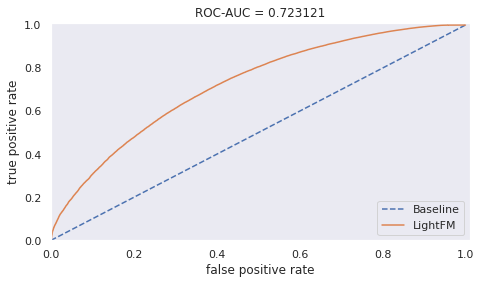

In [94]:
km.plot_roc_curve(test_for_eval.rating, normalized_preds)

## Optimal Parameters

Подберем оптимальное значение величины learning rate, максимизируя ROC-AUC с помощью функции forest_minimize

In [95]:
space = [np.arange(0.04, 0.17, 0.02)] # learning_rate
display(space)
search_params_list = []

def objective_lr_search(params):
    return km.objective(params, ratings_coo.copy(), test_for_eval, search_params_list)

res_fm = forest_minimize(objective_lr_search,
                         space,
                         n_calls=10,
                         random_state=RANDOM_SEED,
                         verbose=False,
                         n_jobs=1)

print(sorted(search_params_list))
print()
print('Maximum ROC-AUC: {:7.6f}'.format(-res_fm.fun))
print('Optimal learning rate: {:3.2f}'.format(res_fm.x[0]))

[array([0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16])]

[[0.04, 0.71053], [0.06, 0.724079], [0.06, 0.724079], [0.08, 0.725893], [0.1, 0.723121], [0.1, 0.723121], [0.12, 0.719451], [0.12, 0.719451], [0.14, 0.716155], [0.14, 0.716155]]

Maximum ROC-AUC: 0.725893
Optimal learning rate: 0.08


## Submission

Для итогового предсказания на тестовых данных заново обучим модель на всей тренировочной выборке. <br>В модели используется ранее подобранное оптимальное значение learning rate. <br>Для улучшения score применим блендинг в виде усреднения результатов 15ти моделей LightFM с различным random_state

In [96]:
ratings_coo = km.get_ratings_coo_matrix(train_for_model)
params = km.get_std_model_params()
params['learning_rate'] = 0.08

train_user_features = km.get_features_from_ids(train_for_model['userid'])
train_item_features = km.get_features_from_ids(train_for_model['itemid'])

test_user_features = km.get_features_from_ids(test_for_model['userid'])
test_item_features = km.get_features_from_ids(test_for_model['itemid'])

preds = np.zeros(test.userid.values.shape[0], dtype=np.float)
num_steps = 1
items_repres_list = []

for n in range(1,num_steps+1):
    params['random_state'] = RANDOM_SEED * n
    model = LightFM(**params)

    model = model.fit(ratings_coo.copy(),
                      user_features=train_user_features.copy(),
                      item_features=train_item_features.copy(),
                      epochs=NUM_EPOCHS,
                      num_threads=NUM_THREADS)
    
    # features=None
    items_repres_list.append(model.get_item_representations(features=train_item_features.copy()))

    preds += model.predict(test_for_model.userid.values,
                           test_for_model.itemid.values,
                           user_features=test_user_features.copy(),
                           item_features=test_item_features.copy())
else:
    preds /= num_steps

In [97]:
# cold start users/items
preds_cs = []
idx_cs = []
userid_values = test_for_model.userid.values
itemid_values = test_for_model.itemid.values

for idx in range(len(preds)):
    if userid_values[idx] in missed_userid_train or itemid_values[idx] in missed_itemid_train:
        idx_cs.append(idx)
        preds_cs.append(preds[idx])

In [98]:
display([preds.min(), preds.max()], np.unique(preds))
normalized_preds = km.normalize_predictions(preds)
display([normalized_preds.min(), normalized_preds.max()], np.unique(normalized_preds))

[-25.217079162597656, 29.73948860168457]

array([-25.21707916, -22.96068764, -22.95836258, ...,  26.13614464,
        26.18126869,  29.7394886 ])

[0.0, 1.0]

array([0.        , 0.04105772, 0.04110003, ..., 0.93443288, 0.93525396,
       1.        ])

In [99]:
# normalized_preds[idx_cs] = 0.5
# normalized_preds[idx_cs]

In [100]:
ids_0 = submission['Id'].values
ids_1 = test_id_col.values
np.array_equal(ids_0, ids_1), ids_0.shape == ids_1.shape

(True, True)

In [101]:
submission['rating'] = normalized_preds
submission.to_csv('submission_log.csv', index=False)
# submission.query('rating == -1').shape[0]

# Recommendations to Item

Воспользуемся обученной моделью, чтобы получить новые векторные представления товаров. В нашем случае одному товару соответствует NUM_COMPONENTS = 30 чисел. Эти эмбеддинги используются для получения рекомендации, а именно для поиска наиболее похожих. Для этого применяется метод ближайших соседей, approximate k-nn, который реализован в библиотеке nmslib. Особенностью реализации является быстрый обход графа при поиске

In [102]:
item_biases, item_embeddings = items_repres_list[0]
display(item_biases.shape, item_embeddings.shape, num_items, train_for_model.itemid.nunique())

(41320,)

(41320, 30)

41320

41302

Сохраните модель (точнее, векторные представления), используя модуль Pickle, под названием item_embeddings.pickle. В дальнейшем сохраненные представления будут использованы в деплое модели

In [103]:
import pickle
with open('item_embeddings.pickle', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('item_embeddings.pickle', 'rb') as file:
#     item_embeddings = pickle.load(file)    

In [104]:
# Создаём граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')

# Добавляем в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

# Вспомогательная функция для поиска по графу
def nearest_items_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

Выберем случайный товар для получения рекомендаций

In [105]:
test_itemid = 250
# test_itemid = 33885
test_itemid in missed_itemid_train, test_itemid in train_for_model.itemid.values, test_itemid in test_for_model.itemid.values

(False, True, True)

In [106]:
res = nearest_items_nms(test_itemid, nms_idx)
display(res)
nbm = res[0]

(array([  250, 39426, 10520,  4179, 27701, 24859, 31898,  9393,  4059,
        30622], dtype=int32),
 array([0.        , 0.20838273, 0.34416223, 0.35739982, 0.38193226,
        0.38534325, 0.38649684, 0.39598495, 0.39598566, 0.40009195],
       dtype=float32))

In [107]:
res = nearest_items_nms(test_itemid, nms_idx, 5)
display(res)
nbm = res[0]

(array([  250, 39426, 10520,  4179, 27701], dtype=int32),
 array([0.        , 0.20838273, 0.34416223, 0.35739982, 0.38193226],
       dtype=float32))

In [108]:
pred_items_asin = [itemid_2_asin_dict[itemid] for itemid in nbm]
print(pred_items_asin)
df_pred = meta_data_prepared[meta_data_prepared['asin'].isin(pred_items_asin)]
display(df_pred)

['B00015UC6G', 'B00430MA5Q', 'B002AQKYEE', 'B000Q5ZMD4', 'B00IO2I20G']


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,num_also_buy,num_also_view
1798,"[Grocery & Gourmet Food, Cooking & Baking]",[Potato starch tolerates higher temperatures t...,"Potato Starch, 1 lb. by Barry Farm",Barry Farm,102.622,"[B00D39204O, B0013JOKBC, B07BSF4NZJ, B00022DRV...",Grocery,11.75,B00015UC6G,"[B007EFOEOW, B0013JQON4, B00018CWN4, B000LQO55...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,54,38
23456,"[Grocery & Gourmet Food, Deli, Packaged & Slic...",[Enjoy premium sliced ham at home with Hillshi...,"Hillshire Farm Ultra Thin Sliced Lunchmeat, Ho...",Hillshire Farm,0.000,NaN,Grocery,11.75,B000Q5ZMD4,"[B07CX6LN8T, B07G38C4JG, B07G348HYR, B01AZ15E22]",[https://images-na.ssl-images-amazon.com/image...,NaN,[Please refer the ingredient list on the detai...,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,4,0
55489,"[Grocery & Gourmet Food, Cooking & Baking, Bak...",[Fiber One banana nut muffin mix has bananas a...,"Fiber One Banana Nut Muffin Mix, 15.3-Ounce Bo...",Fiber One,446.218,NaN,Grocery,11.75,B002AQKYEE,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,0,0
67671,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Granulated Lemon Peel is all natural and cont...,"The Spice Hunter Lemon Peel, Granulated, 2.1-O...",Spice Hunter,449.196,NaN,Grocery,11.75,B00430MA5Q,NaN,NaN,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Package ...",NaN,NaN,0,0
185780,"[Grocery & Gourmet Food, Snack Foods, Cookies,...","[Cinnamon-Sugar Spice, that's what our crisp B...",Lu Cinnamon Sugar Spice European Biscuit Cooki...,Lu,41.090,NaN,Grocery,28.29,B00IO2I20G,"[B0019FEOJI, B008L0IAQW, B00R6GAJSY, B003D5JJE...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,23,0


К товару из категории Grocery рекомендуются похожие товары из той же категории, различной цены и брендов <br><br>Для прототипа модели необходимо выбрать признак по которому пользователь будет искать нужный товар. Наиболее подходящий это title, содержащий краткое название. Несмотря на наличие повторов и пропусков, будем использовать именно его, предлагая пользователю указать название или ключевое слово, относящееся к товару

In [109]:
meta_data_prepared.shape, meta_data_prepared.title.nunique(), meta_data_prepared.title.value_counts().iloc[:15]

((283512, 18),
 275949,
 Unknown                                                                                                                                                          5697
 Mr & Mrs Bride and Groom Silhouette Wedding Cake Topper Pick COVERED WITH A PROTECTIVE LAYER WHICH SHOULD BE TORN OFF BEFORE USE(29 optional kinds of styles)      28
 2" ~ Disney Princess Sofia the First Birthday ~ Edible Image Cake/Cupcake Topper!!!                                                                                13
 Allegro Tea, Organic Happy Tummy Tea Bags, 20 ct                                                                                                                   11
 New Matcha House Premium Ceremonial Grade Green Tea Powder 84g (3oz) - No Additives - Radiation Free - Zero Sugar - First Harvest - FDA Organic Certified          11
 Vue Portion Pack                                                                                                                            

# Model Prototype

Пользовательский интерфейс прототипа модели реализован с помощью библиотеки Streamlit. <br><br>Прототип размещен на сервере Heroku и доступен по ссылке https://polar-cove-18620.herokuapp.com/

# Efficiency for Business

Выбор метрики эффективности внедренной модели

...